In [1]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
processed=pd.read_csv('drive/My Drive/HeartDeases_dataset/processed.cleveland.data.csv')
reprocessed=pd.read_csv('drive/My Drive/HeartDeases_dataset/reprocessed_hungarian_data.csv')

In [43]:
processed.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [44]:
processed.target.unique()

array([0, 2, 1, 3, 4])

In [45]:
len(processed)

303

In [46]:
reprocessed=reprocessed.iloc[:,:-1]
reprocessed.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,40,1,2,140,289,0,0,172,0,0.0,-9,-9,-9,0
1,49,0,3,160,180,0,0,156,0,1.0,2,-9,-9,1
2,37,1,2,130,283,0,1,98,0,0.0,-9,-9,-9,0
3,48,0,4,138,214,0,0,108,1,1.5,2,-9,-9,3
4,54,1,3,150,-9,0,0,122,0,0.0,-9,-9,-9,0


In [47]:
reprocessed.target.unique()

array([0, 1, 3, 4, 2])

In [48]:
len(reprocessed)

294

In [49]:
data=pd.concat([processed,reprocessed])
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


## Handling Missing Values

In [0]:
# mark all missing values
data.replace('?', np.nan, inplace=True)
# make dataset numeric
data = data.astype('float32')

In [0]:
columns=data.columns
X=data.values

from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
X[:,:-1]=imputer.fit_transform(X[:,:-1])

imputer2 =SimpleImputer(missing_values=np.nan,strategy='most_frequent')
X[:,-1:]=imputer2.fit_transform(X[:,-1:])

In [52]:
data=pd.DataFrame(data=X,columns=columns)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0


# Data Preprocessing

## Select import Feature based on correlation


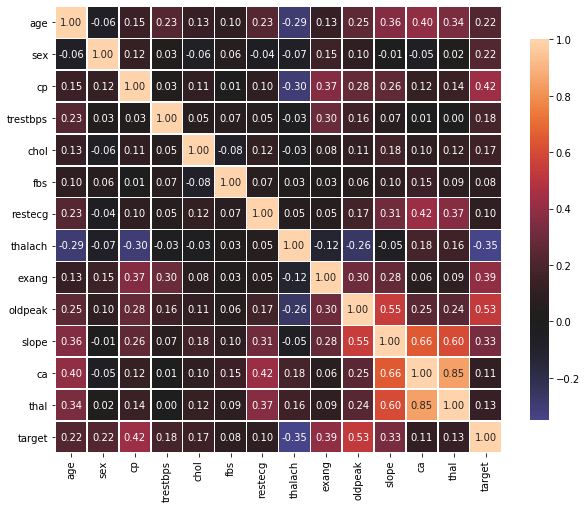

In [53]:
def correlation_heatmap(data):
    correlations = data.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
correlation_heatmap(data)


In [0]:
corr = data.corr()

In [0]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data = data[selected_columns]

In [56]:
data.shape

(597, 14)

In [0]:
import statsmodels.regression.linear_model as sm
selected_columns = selected_columns[:-1].values
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05
data_modeled, selected_columns = backwardElimination(data.iloc[:,:-1].values, data.iloc[:,-1].values, SL, selected_columns)

In [0]:
final_data=pd.DataFrame(data=data_modeled,columns=selected_columns)

In [59]:
final_data.head()

,sex,cp,trestbps,chol,thalach,exang,oldpeak
0,1.0,1.0,145.0,233.0,150.0,0.0,2.3
1,1.0,4.0,160.0,286.0,108.0,1.0,1.5
2,1.0,4.0,120.0,229.0,129.0,1.0,2.6
3,1.0,3.0,130.0,250.0,187.0,0.0,3.5
4,0.0,2.0,130.0,204.0,172.0,0.0,1.4


In [0]:
final_data['target']=data.iloc[:,-1]

In [61]:
final_data.head()

,sex,cp,trestbps,chol,thalach,exang,oldpeak,target
0,1.0,1.0,145.0,233.0,150.0,0.0,2.3,0.0
1,1.0,4.0,160.0,286.0,108.0,1.0,1.5,2.0
2,1.0,4.0,120.0,229.0,129.0,1.0,2.6,1.0
3,1.0,3.0,130.0,250.0,187.0,0.0,3.5,0.0
4,0.0,2.0,130.0,204.0,172.0,0.0,1.4,0.0


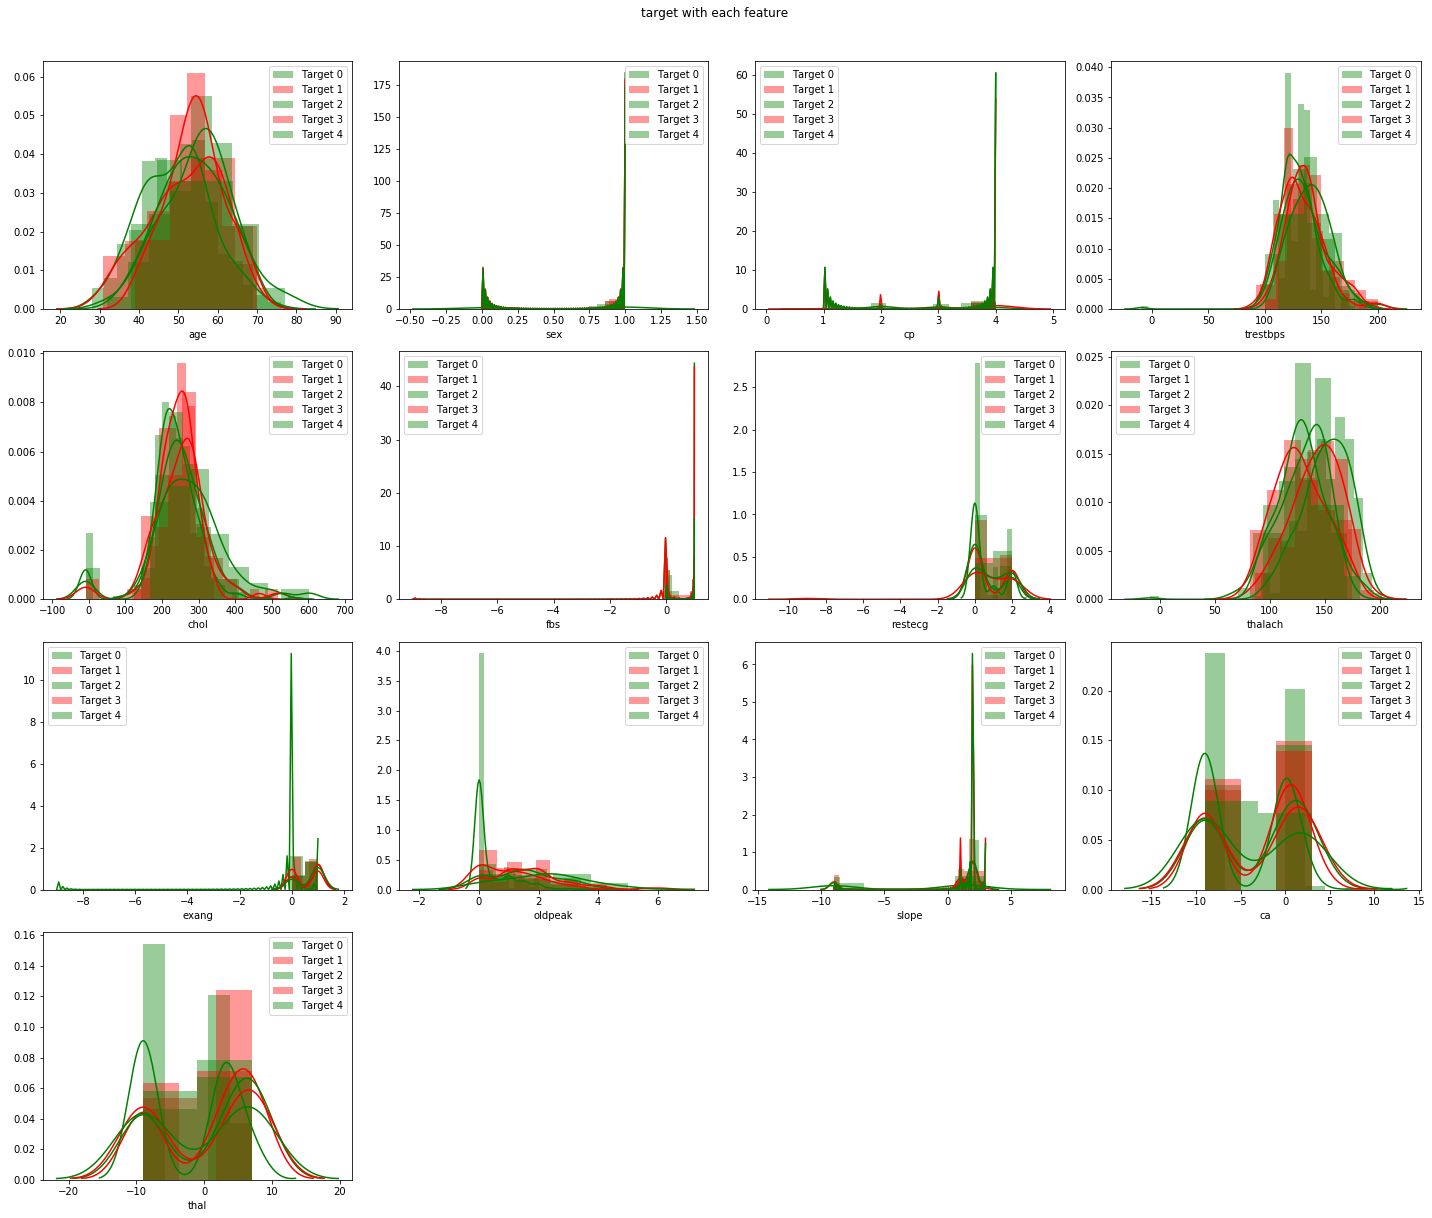

In [62]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data.columns:
    if(i=='target'):
      break;
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(data[i][data['target']==0], color='g', label = 'Target 0')
    sns.distplot(data[i][data['target']==1], color='r', label = 'Target 1')
    sns.distplot(data[i][data['target']==2], color='g', label = 'Target 2')
    sns.distplot(data[i][data['target']==3], color='r', label = 'Target 3')
    sns.distplot(data[i][data['target']==4], color='g', label = 'Target 4')
    plt.legend(loc='best')
fig.suptitle('target with each feature ')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [0]:
classes_count=data.target.value_counts()

Text(0.5, 1.0, 'Records in each class')

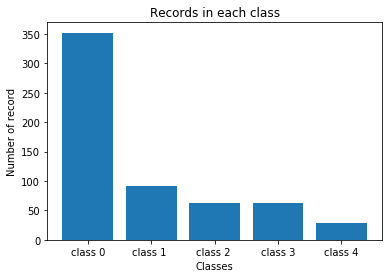

In [64]:
x=[1,2,3,4,5]
plt.bar(x,classes_count)
plt.xticks(x,['class 0','class 1 ','class 2 ','class 3', 'class 4','class 5'])
plt.xlabel('Classes')
plt.ylabel('Number of record')
plt.title('Records in each class')

In [0]:
X=final_data.iloc[:,:-1].values
y=final_data.iloc[:,-1].values

# Data Augmentation 

In [66]:
from collections import Counter
print("Before OverSampling, counts of label ': {}".format(Counter(y))) 
  

from imblearn.over_sampling import SVMSMOTE 
sm = SVMSMOTE(random_state = 2,sampling_strategy='auto',) 
X_res, y_res = sm.fit_sample(X, y.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape)) 
  

print("After OverSampling, counts of label ': {}".format(Counter(y_res))) 


Before OverSampling, counts of label ': Counter({0.0: 352, 1.0: 92, 3.0: 63, 2.0: 62, 4.0: 28})
After OverSampling, the shape of train_X: (1459, 7)
After OverSampling, the shape of train_y: (1459,) 

After OverSampling, counts of label ': Counter({0.0: 352, 1.0: 352, 3.0: 352, 4.0: 222, 2.0: 181})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_res,y_res,test_size=0.1,shuffle=True)

In [79]:
from sklearn.svm import SVC
model=SVC(kernel='rbf',gamma=0.1, C=1.0)
model.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred=model.predict(x_test)

In [81]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

print((accuracy_score(y_test, y_pred))*100,'%')

73.97260273972603 %


In [82]:
# print classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.57      0.98      0.72        44
         1.0       0.95      0.59      0.73        34
         2.0       0.78      0.44      0.56        16
         3.0       0.93      0.71      0.81        35
         4.0       0.93      0.76      0.84        17

    accuracy                           0.74       146
   macro avg       0.83      0.70      0.73       146
weighted avg       0.81      0.74      0.74       146



In [105]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(max_depth=10)
model1.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
y_pred=model1.predict(x_test)

In [107]:
print((accuracy_score(y_test, y_pred))*100,'%')
# print classification report 
print(classification_report(y_test, y_pred))

80.13698630136986 %
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83        44
         1.0       0.76      0.76      0.76        34
         2.0       0.71      0.62      0.67        16
         3.0       0.85      0.80      0.82        35
         4.0       0.77      1.00      0.87        17

    accuracy                           0.80       146
   macro avg       0.79      0.80      0.79       146
weighted avg       0.80      0.80      0.80       146



In [0]:
#Save classifier
import pickle
filename = 'svm.sav'
pickle.dump(model, open(filename, 'wb'))
filename = 'RF.sav'
pickle.dump(model1, open(filename, 'wb'))

In [116]:
# load the model from disk
filename = 'svm.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result*100 ,'%')

73.97260273972603 %


In [117]:
# load the model from disk
filename = 'RF.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result*100 ,'%')

80.13698630136986 %
